import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from keras.preprocessing import image
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import time

2023-05-09 15:02:25.273208: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 15:02:25.960729: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 15:02:25.962033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 15:02:27.401952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


functions

In [32]:
SAVED_MODEL_BEST_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_LOSS_RESULTS = []
IMG_SIZE = 64
EPOCHS = 200 # try different

In [3]:
def get_image_and_transform(path):
    data = utils.load_img(path, color_mode='grayscale', target_size=(64, 64))
    data = utils.img_to_array(data)
    data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [4]:
def build_dataset(dataset_dir): # build 2 datasets for training and testing
    x_train, y_train = [], []
    classes = sorted(os.listdir(dataset_dir))
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        for image in images:
            full_image_path = os.path.join(class_dir, image)
            if 'ipynb_checkpoints' in full_image_path:
                continue
            x_train.append(get_image_and_transform(full_image_path))
            y_train.append(i)
    return x_train, y_train

In [5]:
def get_examples_and_classes(dataset_dir, num): # return persons' names and persons' ears
    classes = sorted(os.listdir(dataset_dir))
    examples = []
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        examples.append(os.path.join(class_dir, images[num]))

    return classes, examples

In [6]:
def plot(accuracy, loss, val_accuracy, val_loss): # return schedule of accuracy and loss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')

    ax1.set_ylabel('total loss')
    ax1.plot(loss,color='tab:red')
    ax1.plot( val_loss, color='tab:brown')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy')  
    ax2.plot( accuracy, color='tab:blue')
    ax2.plot( val_accuracy, color='tab:green')
    ax2.tick_params(axis='y')
    fig.tight_layout()

In [7]:
def plot_many(title='title', data=[]): # return schedules of accuracy
    for i,o in enumerate(data):
        plt.figure(i)
        plt.plot([i for i in range(EPOCHS)],o, label=title)
        plt.legend(loc='upper left')

In [8]:
def max_or_min_avarage_val(list_of_data, accuracy=True): #return dictionary of average values of lists
    dict_all_l = {}
    for i, o in enumerate(list_of_data):
        dict_all_l[i] = sum(o)/len(o)
    if accuracy:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1], reverse=True))
    else:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1]))

In [9]:
def save_lists(): # save lists of accuracy and loss
    t = time.ctime(time.time())[:-5]
    with open(f'accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_ACCURACY_RESULTS:
            f.write("%s\n" % item)
    # with open(f'loss {t}.txt', 'w') as f:
    #     for item in SAVED_MODEL_BEST_LOSS_RESULTS:
    #         f.write("%s\n" % item)

In [10]:
def read_list_from_file(filename): # read accuracy and loss data  from files
    lst = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            if line in ('', ' ','\n'):
                break
            line = line[1:-2].split(', ')
            lst.append([float(i.strip()) for i in line])
    return lst

In [11]:
def show_best_res(list_of_data): # return max value in every list of accuracy
    max_val = {}
    for i, o in enumerate(list_of_data):
        max_val[i] = max(o)
    return dict(sorted(max_val.items(), key=lambda item: item[1], reverse=True))

dataset

In [12]:
train_folder = "/home/jovyan/dataset/dataset2/train"
test_folder = "/home/jovyan/dataset/dataset2/test"

In [13]:
train_datagen = ImageDataGenerator()#rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator()#rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='grayscale')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            color_mode='grayscale')

# print(training_set.filepaths)
# print(training_set.classes)
# print(training_set.class_indices)


Found 22736 images belonging to 164 classes.
Found 5683 images belonging to 164 classes.


model

In [35]:
def model(in_1=8, in_2=8, in_3=8, in_4=8):
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=3, strides=(1,1), input_shape=(64,64,1), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    

    model.add(Conv2D(filters=in_2,kernel_size=3, strides=1, padding = 'same', activation = 'relu')) # try elu
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=in_3,kernel_size=2, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters=in_4,kernel_size=2, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    # model.add(tf.keras.layers.Dropout(0.1))
    model.add(Dense(units = 512 , activation = 'tanh')) # try delete
    # model.add(Dense(units = 1))
    model.add(Dense(units = 164 , activation = 'softmax'))

    model.compile( optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model
summary_example = model()
summary_example.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                      

choose best hyperparameters

In [15]:
def model_and_best_hyperparameters(nums):
    start_time1 = time.time() 
    for i in nums:
        start_time2 = time.time()
        
        ready_model = model(i,i*2,i*3, i*4)        # change order 
        trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS, validation_data = test_set)
        
        print("for one training time taken: {:.2f} seconds".format(time.time() - start_time2)) # how much time one training take
        
        accuracy = trained_model.history['accuracy']
        loss = trained_model.history['loss']

        SAVED_MODEL_BEST_ACCURACY_RESULTS.append(accuracy)
        SAVED_MODEL_BEST_LOSS_RESULTS.append(loss)
        
    print("for all training time taken: {:.2f} seconds".format(time.time() - start_time1)) # how much time all training take

In [16]:
model_and_best_hyperparameters([16,32])

Epoch 1/100


2023-05-09 15:02:32.128100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 2/32 [>.............................] - ETA: 3s - loss: 5.4524 - accuracy: 0.0000e+00 

2023-05-09 15:02:33.611565: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.
2023-05-09 15:02:33.611701: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.
2023-05-09 15:02:33.738862: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.
2023-05-09 15:02:33.739132: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.


 3/32 [=>............................] - ETA: 3s - loss: 5.4619 - accuracy: 0.0000e+00

2023-05-09 15:02:33.860728: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.
2023-05-09 15:02:33.860930: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25362432 exceeds 10% of free system memory.


32/32 [==============================] - ETA: 0s - loss: 5.3964 - accuracy: 0.0176

2023-05-09 15:02:37.790777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 12s 330ms/step - loss: 5.3964 - accuracy: 0.0176 - val_loss: 5.8857 - val_accuracy: 0.0072
Epoch 2/100
32/32 [==============================] - 8s 256ms/step - loss: 5.0668 - accuracy: 0.0312 - val_loss: 5.3799 - val_accuracy: 0.0160
Epoch 3/100
32/32 [==============================] - 9s 274ms/step - loss: 4.9560 - accuracy: 0.0397 - val_loss: 5.0419 - val_accuracy: 0.0229
Epoch 4/100
32/32 [==============================] - 9s 285ms/step - loss: 4.9148 - accuracy: 0.0381 - val_loss: 4.9193 - val_accuracy: 0.0292
Epoch 5/100
32/32 [==============================] - 10s 309ms/step - loss: 4.6465 - accuracy: 0.0713 - val_loss: 5.0664 - val_accuracy: 0.0289
Epoch 6/100
32/32 [==============================] - 9s 287ms/step - loss: 4.4968 - accuracy: 0.0713 - val_loss: 4.7821 - val_accuracy: 0.0468
Epoch 7/100
32/32 [==============================] - 9s 299ms/step - loss: 4.3199 - accuracy: 0.1045 - val_loss: 4.5223 - val_accuracy: 0.0662
Epoch 8/1

2023-05-09 15:19:32.870984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.5502 - accuracy: 0.0127

2023-05-09 15:19:44.527716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 28s 816ms/step - loss: 5.5502 - accuracy: 0.0127 - val_loss: 5.9812 - val_accuracy: 0.0060
Epoch 2/100
32/32 [==============================] - 27s 864ms/step - loss: 5.1658 - accuracy: 0.0293 - val_loss: 5.5641 - val_accuracy: 0.0109
Epoch 3/100
32/32 [==============================] - 27s 858ms/step - loss: 5.1065 - accuracy: 0.0244 - val_loss: 5.3608 - val_accuracy: 0.0165
Epoch 4/100
32/32 [==============================] - 27s 850ms/step - loss: 5.0191 - accuracy: 0.0332 - val_loss: 5.3645 - val_accuracy: 0.0160
Epoch 5/100
32/32 [==============================] - 26s 830ms/step - loss: 4.8650 - accuracy: 0.0576 - val_loss: 5.1801 - val_accuracy: 0.0236
Epoch 6/100
32/32 [==============================] - 27s 856ms/step - loss: 4.8348 - accuracy: 0.0557 - val_loss: 5.0938 - val_accuracy: 0.0297
Epoch 7/100
32/32 [==============================] - 26s 823ms/step - loss: 4.6917 - accuracy: 0.0693 - val_loss: 5.0064 - val_accuracy: 0.0313
Epoc

In [23]:
print("sorted list of average  epochs' values for accuracy  ", max_or_min_avarage_val(SAVED_MODEL_BEST_ACCURACY_RESULTS))
print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS))
# save_lists()

sorted list of average  epochs' values for accuracy   {0: 0.5242283606901765, 1: 0.5135012087970972}
sorted list of max  epochs' values for accuracy   {1: 0.8544921875, 0: 0.8330078125}


In [18]:
# file = 'accuracy Sat May  6 11:19:23.txt'
# l = read_list_from_file(file)
# print("sorted list of max  epochs' values for accuracy  ", show_best_res(l))

train and save model

In [33]:
def final_model():
    ready_model = model(8,16,32,64)
    call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS, validation_data = test_set, callbacks = [call_back])
    return trained_model, ready_model


In [36]:
history, trained_model = final_model()

Epoch 1/130


2023-05-09 16:55:13.523454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.3723 - accuracy: 0.0166

2023-05-09 16:55:16.985419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 8s 200ms/step - loss: 5.3723 - accuracy: 0.0166 - val_loss: 5.6321 - val_accuracy: 0.0084
Epoch 2/130
32/32 [==============================] - 8s 263ms/step - loss: 5.0982 - accuracy: 0.0303 - val_loss: 5.1970 - val_accuracy: 0.0139
Epoch 3/130
32/32 [==============================] - 7s 223ms/step - loss: 5.0441 - accuracy: 0.0387 - val_loss: 5.0103 - val_accuracy: 0.0227
Epoch 4/130
32/32 [==============================] - 6s 180ms/step - loss: 4.8009 - accuracy: 0.0654 - val_loss: 4.9055 - val_accuracy: 0.0283
Epoch 5/130
32/32 [==============================] - 5s 172ms/step - loss: 4.6689 - accuracy: 0.0625 - val_loss: 4.8538 - val_accuracy: 0.0301
Epoch 6/130
32/32 [==============================] - 6s 176ms/step - loss: 4.6374 - accuracy: 0.0664 - val_loss: 4.7735 - val_accuracy: 0.0401
Epoch 7/130
32/32 [==============================] - 5s 172ms/step - loss: 4.4324 - accuracy: 0.0879 - val_loss: 4.7573 - val_accuracy: 0.0447
Epoch 8/130

plot model

In [21]:
# plot_many('accuracy', SAVED_MODEL_BEST_ACCURACY_RESULTS)


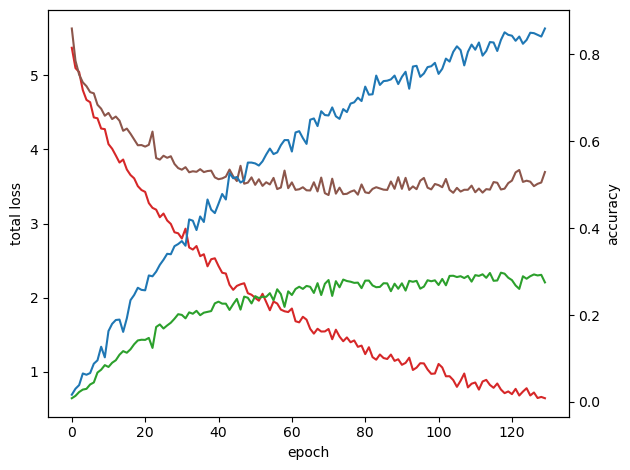

In [38]:
if trained_model:
    plot(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

predict

In [39]:
predict_model = Sequential()
for layer in trained_model.layers[:-1]:
    predict_model.add(layer)
predict_model.add(Dense(units=1, activation=None))
predict_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
predict_model.summary()


predict_model.load_weights('weights.hdf5', skip_mismatch=True, by_name=True)

# # Load weights and biases from model manually
# for i in range(len(predict_model.layers) - 1):
#     predict_model.layers[i].set_weights(model.layers[i].get_weights())


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                     

In [43]:
def predict(model, known_data_path, unknown_data_path):
    known_data = get_image_and_transform(known_data_path)
    unknown_data = get_image_and_transform(unknown_data_path)

    known_data = model.predict(known_data)
    unknown_data = model.predict(unknown_data)
    distance = unknown_data - known_data

    threshold = 0.018614814
    return  distance[0][0] < threshold, distance[0][0]

predict(predict_model, '/home/jovyan/12.jpg', '/home/jovyan/22.jpg')

1/1 [==============================] - 0s 16ms/step


(True, -0.0030766726)

plot prediction

In [44]:
classes, examples1 = get_examples_and_classes(test_folder,1)
classes, examples2 = get_examples_and_classes(test_folder,2)
y_true = [i for i in range(len(classes))]
y_predict_tensors = []
y_predict_labels = []

for i in range(len(classes)):
    predict_label, predict_tensor = predict(predict_model, examples1[i], examples2[i])
    y_predict_tensors.append(predict_tensor)
    y_predict_labels.append(predict_label)    

1/1 [==============================] - 0s 16ms/step


In [45]:
print(classification_report(y_true, y_predict_labels, target_names=classes))

                          precision    recall  f1-score   support

              001.ALI_HD       0.00      0.00      0.00         1
          002.LeDuong_BL       0.01      1.00      0.01         1
             003.BD_Tran       0.00      0.00      0.00         1
                004.Binz       0.00      0.00      0.00         1
              005.Bui_AT       0.00      0.00      0.00         1
             006.Chau_GK       0.00      0.00      0.00         1
             007.Chau_KP       0.00      0.00      0.00         1
               008.Chi_D       0.00      0.00      0.00         1
              009.Chi_Th       0.00      0.00      0.00         1
               010.Chu_B       0.00      0.00      0.00         1
             011.Cong_To       0.00      0.00      0.00         1
            012.Dai_Nhan       0.00      0.00      0.00         1
          013.Dam_Vinh_H       0.00      0.00      0.00         1
              014.Dan_Ng       0.00      0.00      0.00         1
         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


choose best threshold

In [46]:
thresholds = np.linspace(0.0001, 0.5, 1000)

# Calculate F1 score for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_predict_tensors < threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred, average='micro'))

# Choose the threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold

0.0001